In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# Bước 1: Load dữ liệu

In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZ5RST5/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZ5RST5/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZ5RST5/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b"what a preposterous story ,murder blackmail,child sex allegations ,gays and the catholic church.....absolute tripe. How is it that most UK based TV dramas ,sit coms etc have to include the obligortory Gay,its really getting tiresome now. Everybody accepts that there are Gay people in society just has there are other minority groups,but we don't want it ramming down our throats(i'll pass on this one) in every single show. Apart from the above, the drama went from what could have been an interesting little story into a pantomime,the priest was a paedophile and there are gays running about every where,oh yes just to be totally PC one of the gay couple was black.i am surprised at c ecclestone for even contemplating this when he read the script."
 b'This was a gem. Amazing acting from the leads Liam Cunningham, Orla Brady and all the supporting cast. The movie raises a subject not only pertinent to Ireland and Irish history but to many communities around the world and many marria

# Bước 2: Text Encoder

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 49,   4,   1, ...,   0,   0,   0],
       [ 11,  14,   4, ...,   0,   0,   0],
       [255,  22,  29, ...,   0,   0,   0]])

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 49,   4,   1, ...,   0,   0,   0],
       [ 11,  14,   4, ...,   0,   0,   0],
       [255,  22,  29, ...,   0,   0,   0]])

# Bước 3: build model

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [27]:
history = model.fit(train_dataset, epochs=5, \
                    validation_data=test_dataset, \
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 127s 300ms/step - loss: 0.6905 - accuracy: 0.5000 - val_loss: 0.6781 - val_accuracy: 0.4917
Epoch 2/5
391/391 [==============================] - 113s 286ms/step - loss: 0.5515 - accuracy: 0.6920 - val_loss: 0.4663 - val_accuracy: 0.7583
Epoch 3/5
391/391 [==============================] - 113s 286ms/step - loss: 0.4024 - accuracy: 0.8183 - val_loss: 0.3766 - val_accuracy: 0.8344
Epoch 4/5
391/391 [==============================] - 112s 285ms/step - loss: 0.3577 - accuracy: 0.8463 - val_loss: 0.3505 - val_accuracy: 0.8490
Epoch 5/5
391/391 [==============================] - 113s 287ms/step - loss: 0.3359 - accuracy: 0.8562 - val_loss: 0.3378 - val_accuracy: 0.8516


In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 49s 124ms/step - loss: 0.3305 - accuracy: 0.8555
Test Loss: 0.330500990152359
Test Accuracy: 0.8555200099945068


(0.0, 0.7082469671964645)

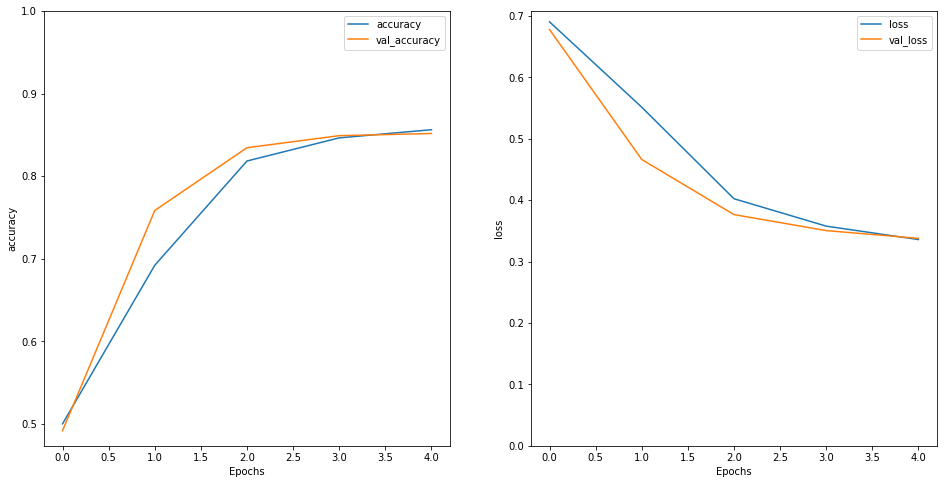

In [29]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)